# sklearn and stochastic gradient descent

Until now we've been using the more standard LassoCV, RidgeCV, etc. (or GridSearchCV) to find our optimal parameters. Unfortunately, though these methods work well on smaller datasets with relatively small numbers of columns, once you start getting into "Medium Data" these slow down to a crawl, and take up so much memory that fitting them becomes untenable.

This is where stochastic gradient descent comes in. Because of its ability to fit iteratively on portions of the data, it avoids the issue of large datasets. It is the most common algorithm to fit models on large datasets.

---

### Import the packages

In [2]:
import numpy as np
import scipy 
import seaborn as sns
import pandas as pd

import patsy

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

---

### Load the data

I've provided data from the SF assessor's office on housing prices in San Francisco - already cleaned up. However, if you want to try this out on data you've been having trouble fitting, such as the Yelp data for project 5, feel free!


In [3]:
prop = pd.read_csv('/Users/alex/Desktop/DSI-SF-2-akodate/datasets/sf_assessor_value/assessor_value_cleaned.csv')

In [4]:
prop.dtypes

baths               int64
beds                int64
lot_depth         float64
basement_area     float64
front_ft          float64
owner_pct         float64
rooms               int64
property_class     object
neighborhood       object
tax_rate          float64
volume              int64
sqft                int64
stories             int64
year_recorded       int64
year_built          int64
zone               object
value             float64
dtype: object

---

### Sample down the data

For demonstration purposes and the sake of speed, I am sampling down this large dataset to a more reasonable amount of rows. 

Stochastic gradient descent is much faster, but the real benefit in my opinion is that it can fit much larger datasets. That being said, it is still slow to fit on huge datasets in sklearn. I don't recommend fitting on the entire data. This is actually my recommendation in general; finding the optimal parameters with more and more data will change the hyperparameters but often with marginal returns.

In [5]:
prop_samp = prop.sample(frac=0.05)

---

### SGD with regression

Below I set up X, y data predicting value (housing price) from the remaining variables. There are ~75,000 rows, with 170 columns.

In [6]:
f = 'value ~ '+' + '.join([c for c in prop_samp.columns if not c == 'value'])+' -1'
print f
y, X = patsy.dmatrices(f, data=prop_samp, return_type='dataframe')
y = y.values.ravel()

print y.shape, X.shape

value ~ baths + beds + lot_depth + basement_area + front_ft + owner_pct + rooms + property_class + neighborhood + tax_rate + volume + sqft + stories + year_recorded + year_built + zone -1
(37707,) (37707, 168)


---

### Import the modeling classes

`SGDRegressor` and `SGDClassifer` are the models used in this solution These are the very general, flexible stochastic gradient descent classes.

In [7]:
from sklearn.linear_model import (LinearRegression, LogisticRegression, 
                                  Lasso, Ridge,
                                  SGDRegressor, SGDClassifier)
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

import scipy.stats as stats


---

### Standardize the data

Always a necessary step when performing regularization.

In [8]:
ss = StandardScaler()
Xn = ss.fit_transform(X)
print Xn.shape

(37707, 168)


---

### Run the gridsearch on parameters

SGDRegressor and SGDClassifier use GridSearchCV and RandomizedSearchCV (which will be introduced in the next section) to find the optimal parameters. If you are still unsure of how to use the GridSearchCV, please look this up in the sklearn documentation. I want you to get used to looking things up online - you will be doing this literally every day on the job.

In [9]:
sgd_params = {
    'loss':['squared_loss'],
    'penalty':['l1','l2'],
    'alpha':np.linspace(0.01, 10000, 100)
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=2)

In [10]:
sgd_reg_gs.fit(Xn, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.3s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l1, alpha=0.01, loss=squared_loss -   0.2s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] .............. penalty=l2, alpha=0.01, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=0.01, loss=squared_loss .......................
[CV] ........

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    6.0s


[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l1, alpha=404.05, loss=squared_loss -   0.2s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] ............ penalty=l2, alpha=404.05, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=404.05, loss=squared_loss .....................
[CV] .

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:   25.7s


[CV] ........... penalty=l1, alpha=1616.17, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1616.17, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1616.17, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=1616.17, loss=squared_loss -   0.2s
[CV] penalty=l2, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1616.17, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1616.17, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=1616.17, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=1616.17, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=1616.17, loss=squared_loss ....................
[CV] .

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:  1.0min


[CV] ........... penalty=l1, alpha=3636.37, loss=squared_loss -   0.2s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=3636.37, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=3636.37, loss=squared_loss -   0.1s
[CV] penalty=l1, alpha=3737.38, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=3737.38, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=3737.38, loss=squared_loss ....................
[CV] .

[Parallel(n_jobs=1)]: Done 647 tasks       | elapsed:  1.9min


[CV] ........... penalty=l2, alpha=6464.65, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=6464.65, loss=squared_loss ....................
[CV] ........... penalty=l2, alpha=6464.65, loss=squared_loss -   0.1s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=6565.66, loss=squared_loss ....................
[CV] ........... penalty=l1, alpha=6565.66, loss=squared_loss -   0.2s
[CV] penalty=l2, alpha=6565.66, loss=squared_loss ....................
[CV] .

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss'], 'alpha': array([  1.00000e-02,   1.01020e+02, ...,   9.89899e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [12]:
print sgd_reg_gs.best_params_
print sgd_reg_gs.best_score_
sgd_reg = sgd_reg_gs.best_estimator_

{'penalty': 'l2', 'alpha': 101.02, 'loss': 'squared_loss'}
0.0168448552557


In [13]:
sgd_reg_gs_params = sgd_reg_gs.get_params()
sgd_reg_gs_params

{'cv': 5,
 'error_score': 'raise',
 'estimator': SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
        loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
        random_state=None, shuffle=True, verbose=0, warm_start=False),
 'estimator__alpha': 0.0001,
 'estimator__average': False,
 'estimator__epsilon': 0.1,
 'estimator__eta0': 0.01,
 'estimator__fit_intercept': True,
 'estimator__l1_ratio': 0.15,
 'estimator__learning_rate': 'invscaling',
 'estimator__loss': 'squared_loss',
 'estimator__n_iter': 5,
 'estimator__penalty': 'l2',
 'estimator__power_t': 0.25,
 'estimator__random_state': None,
 'estimator__shuffle': True,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'fit_params': {},
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'alpha': array([  1.00000000e-02,   1.01020000e+02,   2.02030000e+02,
           3.03040000e+02,   4.04050000e+02,   5.05060000e+02,
           6.06070

---

### Visualize or otherwise look at the SGDRegression results

How you choose to examine the results is up to you. Visualizations are always a good idea, but not entirely neccessary (or easy) in this case.

In [14]:

def lasso_coefs(X, Y, alphas):
    coefs = []
    lasso_reg = Lasso()
    for a in alphas:
        lasso_reg.set_params(alpha=a)
        lasso_reg.fit(X, Y)
        coefs.append(lasso_reg.coef_)
        
    return coefs

sgd_reg_alphas = sgd_reg_gs_params['param_grid']['alpha']
lcoefs = lasso_coefs(Xn, y, sgd_reg_alphas)

/Users/alex/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


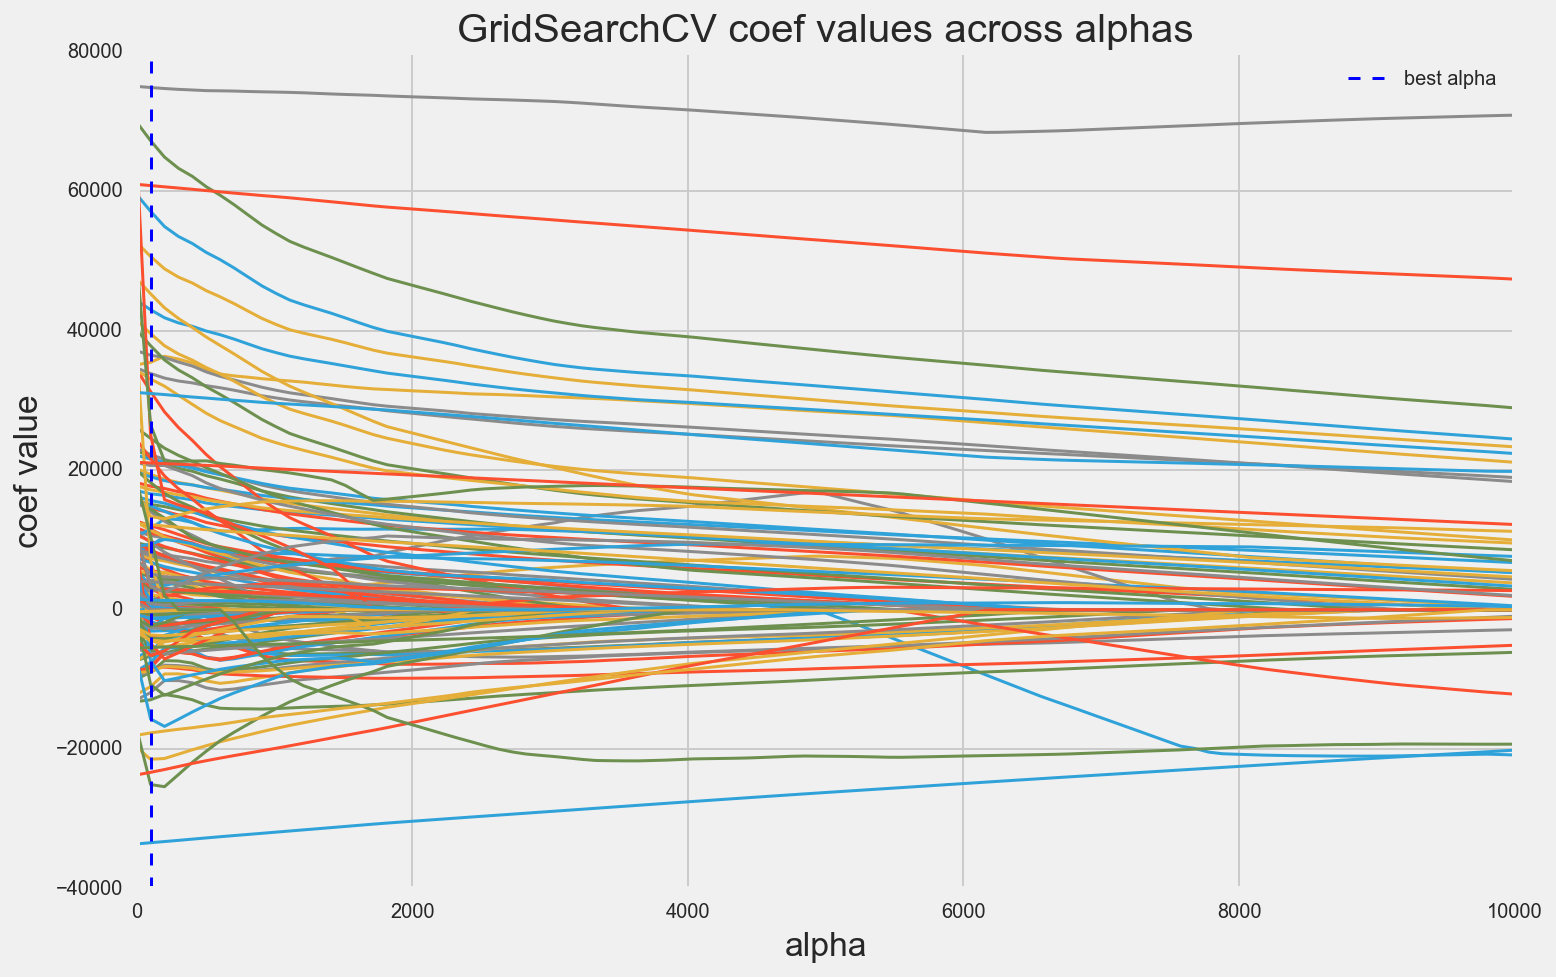

In [15]:
# Plot the coefficients across alpha values:
fig, ax = plt.subplots(figsize=(11,7))

ax.plot(sgd_reg_alphas, lcoefs, lw=1.5)

ax.axvline(sgd_reg_gs.best_params_['alpha'], lw=1.5, ls='dashed', label='best alpha')

ax.set_title('GridSearchCV coef values across alphas')
ax.set_xlabel('alpha')
ax.set_ylabel('coef value')

plt.legend(loc='upper right')

plt.show()

---

### RandomizedSearchCV

This class is very similar to GridSearchCV in the way it is initialized with parameters. The big difference is that instead of searching across a strictly specified grid, it searches over random values that are defined by distributions.

Below I have set up for you an example of parameters and calls to the class.

    uniform: this random variable is from scipy.stats and it pulls random values from the uniform distribution from 0.01 to 20000
    sgd_rand_params: the only difference here is that alpha gets the random variable. It will pull random values from that distribution
    RandomizedSearchCV: this takes an n_iter parameter that specifies how long to search over random values
    
RandomizedSearchCV is often faster than GridSearchCV while getting the same optimal parameteres. However, this is not _always_ the case. As far as I know it is not completely random, but rather begins to favor values that are closer to its current optimum.

For more information, see:

[RandomizedSearchCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html#sklearn.grid_search.RandomizedSearchCV)

[scipy.stats available distributions and functions](http://docs.scipy.org/doc/scipy/reference/stats.html)


In [16]:
uniform = stats.uniform(loc=0.01, scale=20000)

sgd_rand_params = {
    'loss':['squared_loss'],
    'penalty':['l1','l2'],
    'alpha':uniform
}

sgd_reg = SGDRegressor()
sgd_reg_rand_gs = RandomizedSearchCV(sgd_reg, sgd_rand_params, cv=5, verbose=2, n_iter=50)

In [17]:
sgd_reg_rand_gs.fit(Xn, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] penalty=l1, alpha=19755.0898264, loss=squared_loss ..............
[CV] ..... penalty=l1, alpha=19755.0898264, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=19755.0898264, loss=squared_loss ..............
[CV] ..... penalty=l1, alpha=19755.0898264, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=19755.0898264, loss=squared_loss ..............
[CV] ..... penalty=l1, alpha=19755.0898264, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=19755.0898264, loss=squared_loss ..............
[CV] ..... penalty=l1, alpha=19755.0898264, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=19755.0898264, loss=squared_loss ..............
[CV] ..... penalty=l1, alpha=19755.0898264, loss=squared_loss -   0.2s
[CV] penalty=l2, alpha=4318.18893116, loss=squared_loss ..............
[CV] ..... penalty=l2, alpha=4318.18893116, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=4318.18893116, loss=squared_loss ..............
[CV] ..... pena

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    5.8s


[CV] ..... penalty=l1, alpha=14272.2029395, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=14272.2029395, loss=squared_loss ..............
[CV] ..... penalty=l1, alpha=14272.2029395, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=14272.2029395, loss=squared_loss ..............
[CV] ..... penalty=l1, alpha=14272.2029395, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=14272.2029395, loss=squared_loss ..............
[CV] ..... penalty=l1, alpha=14272.2029395, loss=squared_loss -   0.2s
[CV] penalty=l2, alpha=17925.1580226, loss=squared_loss ..............
[CV] ..... penalty=l2, alpha=17925.1580226, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=17925.1580226, loss=squared_loss ..............
[CV] ..... penalty=l2, alpha=17925.1580226, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=17925.1580226, loss=squared_loss ..............
[CV] ..... penalty=l2, alpha=17925.1580226, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=17925.1580226, loss=squared_loss ..............
[CV] .

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:   25.8s


[CV] penalty=l1, alpha=258.632234839, loss=squared_loss ..............
[CV] ..... penalty=l1, alpha=258.632234839, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=258.632234839, loss=squared_loss ..............
[CV] ..... penalty=l1, alpha=258.632234839, loss=squared_loss -   0.2s
[CV] penalty=l1, alpha=258.632234839, loss=squared_loss ..............
[CV] ..... penalty=l1, alpha=258.632234839, loss=squared_loss -   0.2s
[CV] penalty=l2, alpha=4768.74190971, loss=squared_loss ..............
[CV] ..... penalty=l2, alpha=4768.74190971, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=4768.74190971, loss=squared_loss ..............
[CV] ..... penalty=l2, alpha=4768.74190971, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=4768.74190971, loss=squared_loss ..............
[CV] ..... penalty=l2, alpha=4768.74190971, loss=squared_loss -   0.1s
[CV] penalty=l2, alpha=4768.74190971, loss=squared_loss ..............
[CV] ..... penalty=l2, alpha=4768.74190971, loss=squared_loss -   0.1s
[CV] p

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   39.6s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'penalty': ['l1', 'l2'], 'loss': ['squared_loss'], 'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11b85a210>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=2)

In [18]:
print sgd_reg_rand_gs.best_params_
print sgd_reg_rand_gs.best_score_
sgd_rand_reg = sgd_reg_rand_gs.best_estimator_

{'penalty': 'l1', 'alpha': 11323.889637574444, 'loss': 'squared_loss'}
0.214025901953


In [19]:
sgd_reg_rand_gs_params = sgd_reg_rand_gs.get_params()

sgd_reg_rand_alphas = np.linspace(1., np.max(sgd_reg_rand_gs.best_params_['alpha']), 100.)
lcoefs_rand = lasso_coefs(Xn, y, sgd_reg_rand_alphas)

---

### Visualize/examine the results from your RandomizedSearchCV results

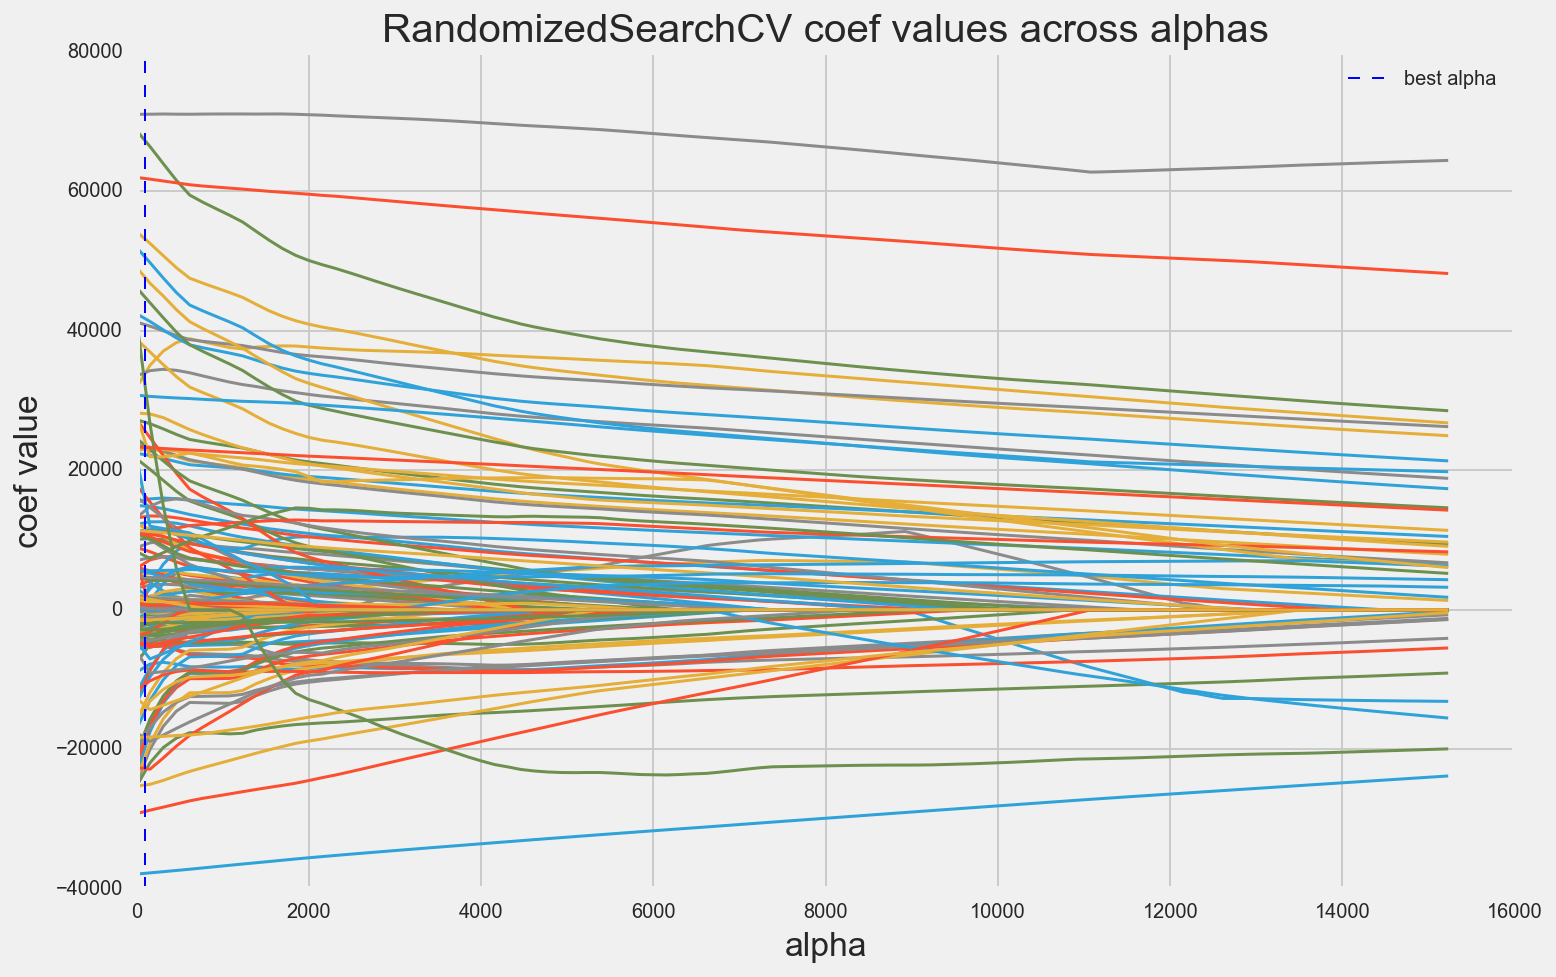

In [21]:
# Plot the coefficients across alpha values:
fig, ax = plt.subplots(figsize=(11,7))

ax.plot(sgd_reg_rand_alphas, lcoefs, lw=1.5)

ax.axvline(sgd_reg_gs.best_params_['alpha'], lw=1.0, ls='dashed', label='best alpha')

ax.set_title('RandomizedSearchCV coef values across alphas')
ax.set_xlabel('alpha')
ax.set_ylabel('coef value')

plt.legend(loc='upper right')

plt.show()

---

### SGDClassifier

Using either GridSearchCV or RandomizedSearchCV, set up an X, y classification problem to look at. Depending on the data you loaded in, you may need to get new data. 

Find the optimal parameters.

In [22]:
ycls = prop_samp.property_class.map(lambda x: 1 if x == 'Z' else 0).values
print np.mean(ycls)

f = '~ '+' + '.join([c for c in prop_samp.columns if not c == 'value'])+' -1'
print f
Xcls = patsy.dmatrix(f, data=prop_samp, return_type='dataframe')

Xclsn = ss.fit_transform(Xcls)
print ycls.shape, Xcls.shape

0.159466412072
~ baths + beds + lot_depth + basement_area + front_ft + owner_pct + rooms + property_class + neighborhood + tax_rate + volume + sqft + stories + year_recorded + year_built + zone -1
(37707,) (37707, 168)


In [23]:
sgd_clf_params = {
    'loss':['log'],
    'penalty':['l1','l2'],
    'alpha':uniform
}

sgd_cls = SGDClassifier()
sgd_cls_gs = RandomizedSearchCV(sgd_cls, sgd_clf_params, cv=5, verbose=2, n_iter=100)

In [24]:
sgd_cls_gs.fit(Xcls, ycls)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] penalty=l1, alpha=4195.33650124, loss=log .......................
[CV] .............. penalty=l1, alpha=4195.33650124, loss=log -   0.2s
[CV] penalty=l1, alpha=4195.33650124, loss=log .......................
[CV] .............. penalty=l1, alpha=4195.33650124, loss=log -   0.2s
[CV] penalty=l1, alpha=4195.33650124, loss=log .......................
[CV] .............. penalty=l1, alpha=4195.33650124, loss=log -   0.2s
[CV] penalty=l1, alpha=4195.33650124, loss=log .......................
[CV] .............. penalty=l1, alpha=4195.33650124, loss=log -   0.2s
[CV] penalty=l1, alpha=4195.33650124, loss=log .......................
[CV] .............. penalty=l1, alpha=4195.33650124, loss=log -   0.2s
[CV] penalty=l1, alpha=4543.07445297, loss=log .......................
[CV] .............. penalty=l1, alpha=4543.07445297, loss=log -   0.2s
[CV] penalty=l1, alpha=4543.07445297, loss=log .......................
[CV] .........

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    6.8s


[CV] .............. penalty=l1, alpha=11238.1392348, loss=log -   0.2s
[CV] penalty=l1, alpha=11238.1392348, loss=log .......................
[CV] .............. penalty=l1, alpha=11238.1392348, loss=log -   0.2s
[CV] penalty=l1, alpha=11238.1392348, loss=log .......................
[CV] .............. penalty=l1, alpha=11238.1392348, loss=log -   0.2s
[CV] penalty=l1, alpha=11238.1392348, loss=log .......................
[CV] .............. penalty=l1, alpha=11238.1392348, loss=log -   0.2s
[CV] penalty=l2, alpha=19914.7542815, loss=log .......................
[CV] .............. penalty=l2, alpha=19914.7542815, loss=log -   0.1s
[CV] penalty=l2, alpha=19914.7542815, loss=log .......................
[CV] .............. penalty=l2, alpha=19914.7542815, loss=log -   0.1s
[CV] penalty=l2, alpha=19914.7542815, loss=log .......................
[CV] .............. penalty=l2, alpha=19914.7542815, loss=log -   0.1s
[CV] penalty=l2, alpha=19914.7542815, loss=log .......................
[CV] .

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:   26.7s


[CV] .............. penalty=l1, alpha=18926.8081367, loss=log -   0.2s
[CV] penalty=l1, alpha=18926.8081367, loss=log .......................
[CV] .............. penalty=l1, alpha=18926.8081367, loss=log -   0.2s
[CV] penalty=l1, alpha=18926.8081367, loss=log .......................
[CV] .............. penalty=l1, alpha=18926.8081367, loss=log -   0.2s
[CV] penalty=l1, alpha=18926.8081367, loss=log .......................
[CV] .............. penalty=l1, alpha=18926.8081367, loss=log -   0.2s
[CV] penalty=l1, alpha=18219.294445, loss=log ........................
[CV] ............... penalty=l1, alpha=18219.294445, loss=log -   0.2s
[CV] penalty=l1, alpha=18219.294445, loss=log ........................
[CV] ............... penalty=l1, alpha=18219.294445, loss=log -   0.2s
[CV] penalty=l1, alpha=18219.294445, loss=log ........................
[CV] ............... penalty=l1, alpha=18219.294445, loss=log -   0.2s
[CV] penalty=l1, alpha=18219.294445, loss=log ........................
[CV] .

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:  1.1min


[CV] .............. penalty=l2, alpha=10163.0042911, loss=log -   0.1s
[CV] penalty=l2, alpha=10163.0042911, loss=log .......................
[CV] .............. penalty=l2, alpha=10163.0042911, loss=log -   0.1s
[CV] penalty=l2, alpha=10163.0042911, loss=log .......................
[CV] .............. penalty=l2, alpha=10163.0042911, loss=log -   0.1s
[CV] penalty=l2, alpha=10163.0042911, loss=log .......................
[CV] .............. penalty=l2, alpha=10163.0042911, loss=log -   0.1s
[CV] penalty=l2, alpha=10163.0042911, loss=log .......................
[CV] .............. penalty=l2, alpha=10163.0042911, loss=log -   0.2s
[CV] penalty=l1, alpha=10940.797114, loss=log ........................
[CV] ............... penalty=l1, alpha=10940.797114, loss=log -   0.2s
[CV] penalty=l1, alpha=10940.797114, loss=log ........................
[CV] ............... penalty=l1, alpha=10940.797114, loss=log -   0.2s
[CV] penalty=l1, alpha=10940.797114, loss=log ........................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'penalty': ['l1', 'l2'], 'loss': ['log'], 'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11a7460d0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=2)

In [25]:
print sgd_cls_gs.best_params_
print sgd_cls_gs.best_score_
sgd_cls = sgd_cls_gs.best_estimator_

{'penalty': 'l1', 'alpha': 4195.3365012364075, 'loss': 'log'}
0.840533587928


In [28]:
sgd_cls_gs_params = sgd_cls_gs.get_params()
sgd_cls_gs_alphas = np.linspace(1., np.max(sgd_cls_gs.best_params_['alpha']), 100)

---

### Visualize/examine the results of the classifier

Just like above.

In [29]:
lcls_coefs = lasso_coefs(Xn, y, sgd_cls_gs_alphas)

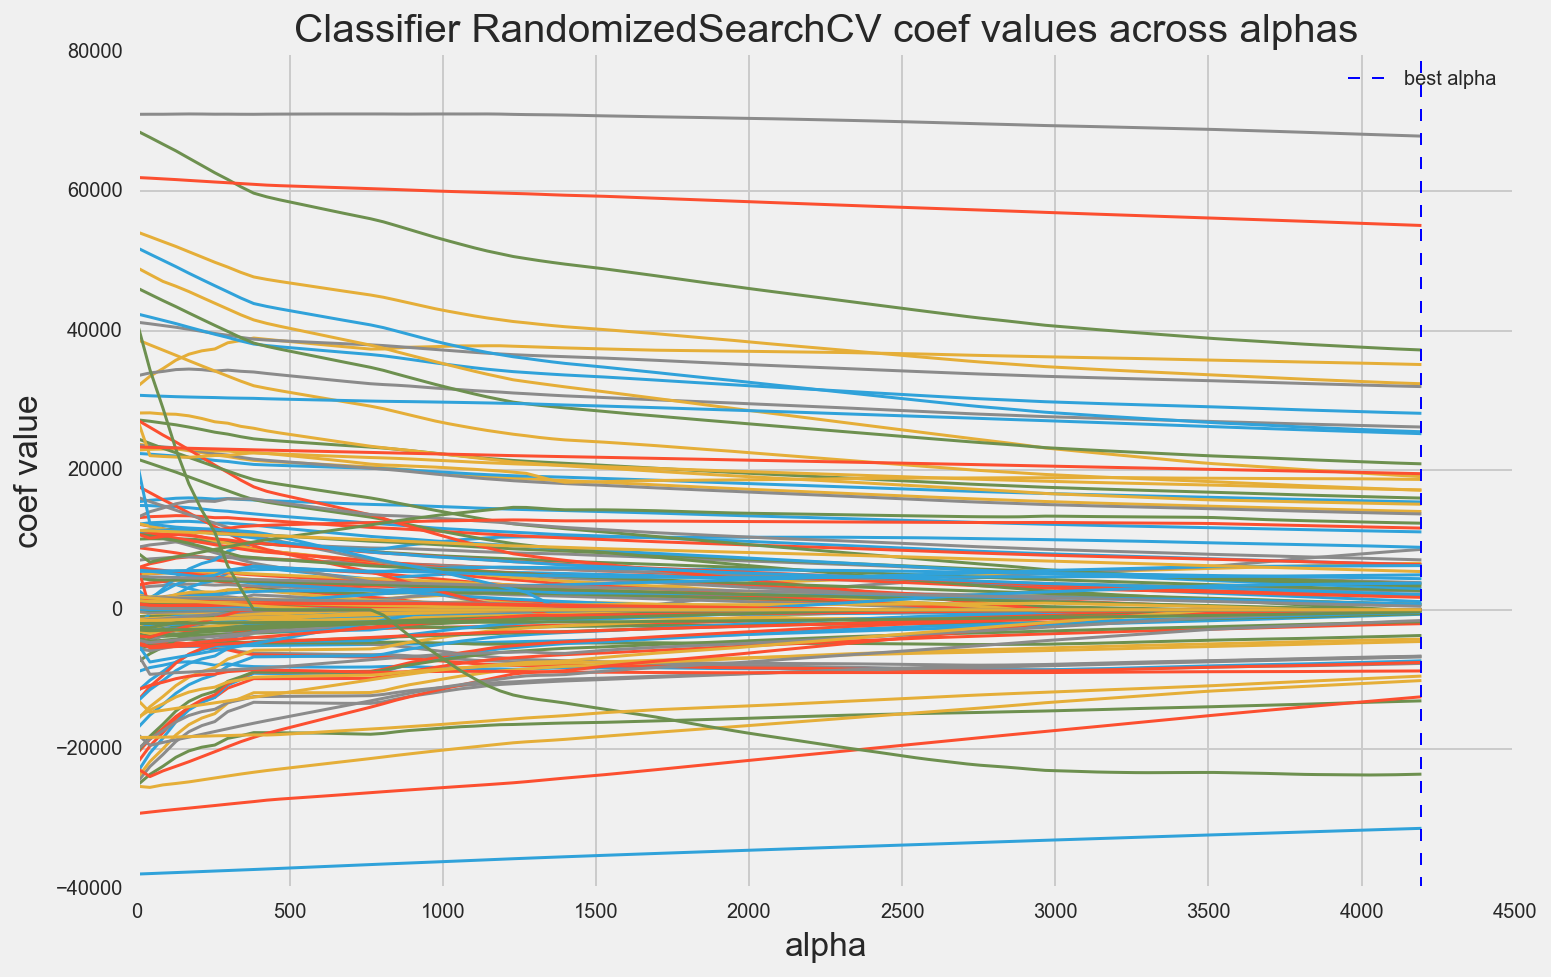

In [30]:
# Plot the coefficients across alpha values:
fig, ax = plt.subplots(figsize=(11,7))

ax.plot(sgd_cls_gs_alphas, lcls_coefs, lw=1.5)

ax.axvline(sgd_cls_gs.best_params_['alpha'], lw=1.0, ls='dashed', label='best alpha')

ax.set_title('Classifier RandomizedSearchCV coef values across alphas')
ax.set_xlabel('alpha')
ax.set_ylabel('coef value')

plt.legend(loc='upper right')

plt.show()